# Predict Future Sales Using Decision Tree Classification

### In this, We are using pandas as data analysis tool and we have used DecisionTreeClassifier to predicted future sales as it is a class capable of performing multi-class classification on a dataset.

In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import time
from sklearn import tree, metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

Wall time: 3.27 s


In [2]:
%%time

salesTrain = pd.read_csv("sales_train.csv/sales_train.csv")
salesTest = pd.read_csv("test.csv/test.csv")

items = pd.read_csv("items.csv/items.csv")
itemCategories = pd.read_csv("item_categories.csv")
shops = pd.read_csv("shops.csv")
sampleSubmission = pd.read_csv("sample_submission.csv/sample_submission.csv")

Wall time: 1.34 s


In [3]:
%%time
salesTrain.head()

Wall time: 0 ns


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
%%time
salesTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
Wall time: 9.97 ms


### As the part of data validation and cleaning, Below we are checking checking if train data have any null vlaues and identified that there are no null values in it so we are good

In [5]:
%%time
salesTrain[salesTrain.isnull().any(axis=1)]

Wall time: 144 ms


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### As the part of data validation and cleaning, Below we are checking  if train data have any negative vlaues and identify those so there are negative values in it so we  need to clean it up

In [6]:
salesTrain[salesTrain['item_cnt_day'] < 0].index

Int64Index([      2,     148,     175,     807,    1041,    1193,    1674,
               1825,    2411,    3216,
            ...
            2932589, 2932636, 2932721, 2933448, 2933712, 2934243, 2934462,
            2935263, 2935643, 2935779],
           dtype='int64', length=7356)

### As the part of data validation and cleaning, Below we are cleaining the rows which has negative count value

In [7]:
salesTrain.drop(salesTrain[salesTrain['item_cnt_day'] < 0].index, inplace = True)

In [8]:
salesTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928493 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.4+ MB


### Below we are checking checking if test data have any null vlaues and identified that there are no null values in it so we are good

In [9]:
%%time
salesTest[salesTest.isnull().any(axis=1)]

Wall time: 3 ms


,ID,shop_id,item_id


### Below we can see the correlation of all columns with the predictor variable, that can help us to identify the variables or required data changes in the model.

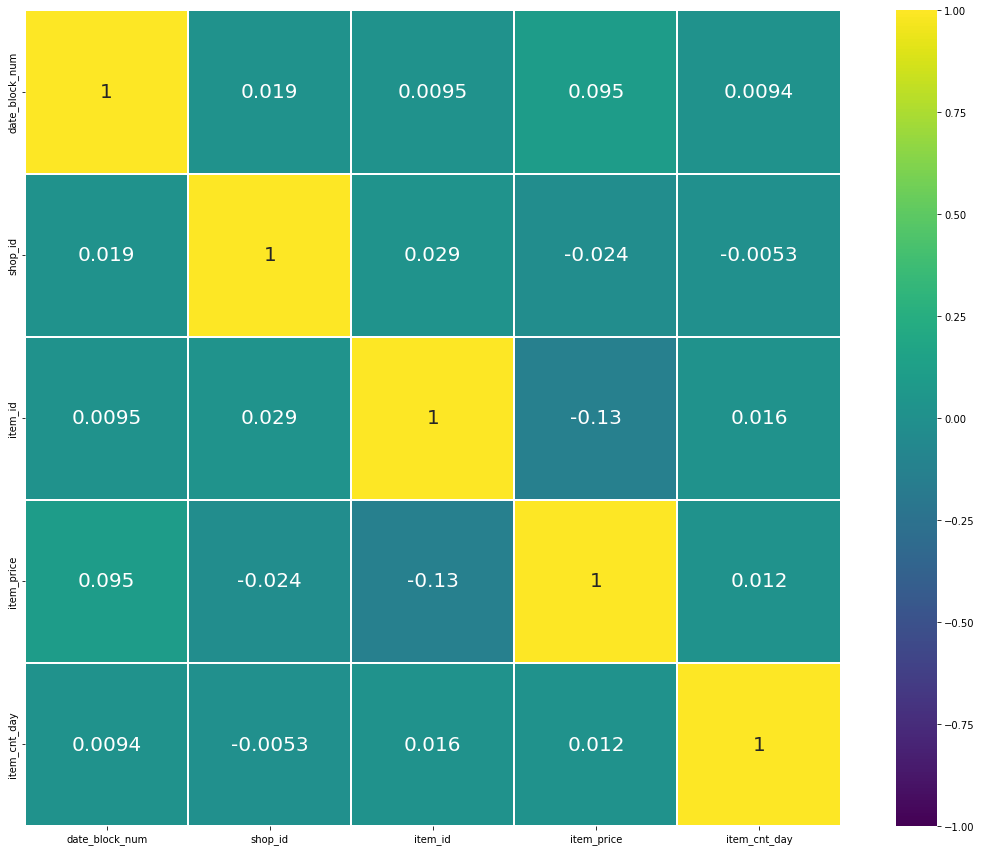

In [10]:
corr = salesTrain.corr()
plt.figure(figsize=(20, 15))

sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 20}, square=True);

### Below we are identifying the count of item sold in each shop in each month by summing the value of items sold in each day though out the month grouping by month, shop and item and creating monthlySales dataframe using pandas index/reindex functionality. So, the the dataframe, it will store number of perticular items sold in each month in each shop 

In [11]:
%%time
monthlySales=salesTrain.groupby(["date_block_num","shop_id","item_id"])["item_cnt_day"].agg(item_cnt_day="sum")

monthlySales['date_block_num'] = monthlySales.index.get_level_values('date_block_num') 
monthlySales['shop_id'] = monthlySales.index.get_level_values('shop_id') 
monthlySales['item_id'] = monthlySales.index.get_level_values('item_id') 
monthlySales.reset_index(drop=True, inplace=True)

monthlySales = monthlySales.reindex(['date_block_num','shop_id','item_id','item_cnt_day'], axis=1)
monthlySales.head()

Wall time: 698 ms


,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


### As from the above dataframe, items sold per date_block_num with respect to shop_id and item_id.So, we are goint to train our model using DecisionTreeClassifier. so as  date_block_num, shop_id and item_id makes composite value to identify respective count sold per date_block_num, lets date_block_num, shop_id and item_id predictor column and item_cnt_day as target value

In [12]:
%%time
columns = ['shop_id','date_block_num','item_id']
predictorColumns = monthlySales[columns]
targetVariable = monthlySales.item_cnt_day

Wall time: 24 ms


### Below, we are finding the accuracy of the model. To find the accuracy of the model, we are using train_test_split to split tarin data in train dataset and test dataset and finding accuracy using accuracy_score

In [13]:
%%time
monthlySalesXTrain, monthlySalesXTest, monthlySalesYTrain, monthlySalesYTest = train_test_split(predictorColumns, targetVariable, test_size=0.3, random_state=1)

Wall time: 228 ms


In [14]:
%%time
decisionTreeClassifierModel = tree.DecisionTreeClassifier(criterion='gini',max_depth=10000) 
decisionTreeClassifierModel.fit(monthlySalesXTrain, monthlySalesYTrain)

Wall time: 12.6 s


DecisionTreeClassifier(max_depth=10000)

In [15]:
%%time
monthlySalesPred = decisionTreeClassifierModel.predict(monthlySalesXTest)

Wall time: 935 ms


In [16]:
%%time
print('The accuracy of Model is '+str(accuracy_score(monthlySalesYTest, monthlySalesPred)))

The accuracy of Model is 0.5418659890396876
Wall time: 32.9 ms


### Below is the text represenatation of decision tree classifier model

In [17]:
%%time
decisionTreeClassifierModelTextRepresentation = tree.export_text(decisionTreeClassifierModel)
print(decisionTreeClassifierModelTextRepresentation)

|--- feature_2 <= 7980.50
|   |--- feature_2 <= 1363.00
|   |   |--- feature_2 <= 1023.50
|   |   |   |--- feature_2 <= 463.50
|   |   |   |   |--- feature_2 <= 35.50
|   |   |   |   |   |--- feature_1 <= 2.50
|   |   |   |   |   |   |--- feature_2 <= 32.50
|   |   |   |   |   |   |   |--- feature_2 <= 29.50
|   |   |   |   |   |   |   |   |--- feature_0 <= 29.50
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- feature_0 >  29.50
|   |   |   |   |   |   |   |   |   |--- feature_2 <= 27.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- feature_2 >  27.50
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= 33.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  33.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |--- feature_2 >  29.50
|   |   |   |   

### Now, in sales test data, we have shop_id and item_id, and consider we have to predict for upcoming month i.e. date_block_num=34, so our test dataframe will have three columns i.e. shop_id, item_id and date_block_num which will help us predict items will be sold in the 34th month.

In [18]:
%%time
decisionTreeClassifierTest = salesTest[['shop_id','item_id']]
decisionTreeClassifierTest.insert(loc=1, column='date_block_num', value='34')  
decisionTreeClassifierTest.head()

Wall time: 3.02 ms


,shop_id,date_block_num,item_id
0,5,34,5037
1,5,34,5320
2,5,34,5233
3,5,34,5232
4,5,34,5268


### Now, we will be using decisionTreeClassifierTest dataframe to predict future sales for the month i.e. for date_block_num = 34 and save in "Prediction_using_decision_tree_classifier.csv"

In [19]:
%%time
predictedFutureSaleOfItems = decisionTreeClassifierModel.predict(decisionTreeClassifierTest)

predictedFutureSaleOfItemsDataFrame = pd.DataFrame(predictedFutureSaleOfItems)
predictedFutureSaleOfItemsDataFrame = predictedFutureSaleOfItemsDataFrame.join(decisionTreeClassifierTest)

predictedFutureSaleOfItemsDataFrame.columns  = ['item_cnt', 'shop_id', 'date_block_num','item_id']
predictedFutureSaleOfItemsDataFrame = predictedFutureSaleOfItemsDataFrame.reindex(['shop_id','date_block_num','item_id','item_cnt'], axis=1)

print(predictedFutureSaleOfItemsDataFrame.head())

predictedFutureSaleOfItemsDataFrame.to_csv("Prediction_using_decision_tree_classifier.csv", sep=',')

   shop_id date_block_num  item_id  item_cnt
0        5             34     5037       1.0
1        5             34     5320       3.0
2        5             34     5233       3.0
3        5             34     5232       1.0
4        5             34     5268       1.0
Wall time: 765 ms


### Below, we are plotting the 3D plot for the predicted future sale of 34th month with respect to shop_id, item_id and the count of item which will be sold

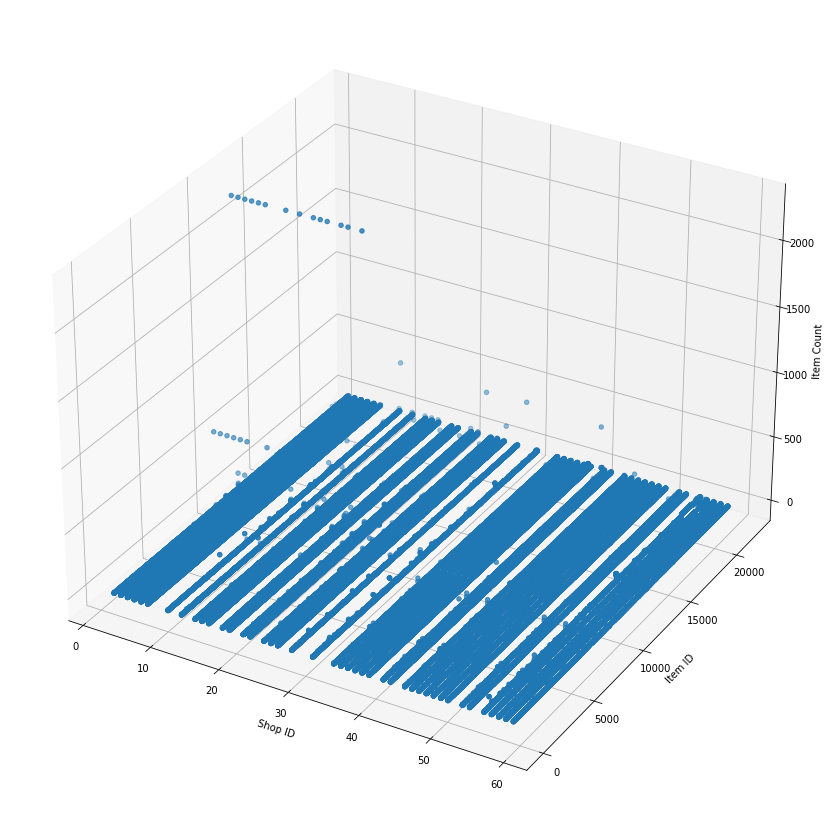

In [20]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(predictedFutureSaleOfItemsDataFrame['shop_id'], predictedFutureSaleOfItemsDataFrame['item_id'], predictedFutureSaleOfItemsDataFrame['item_cnt'])
ax.set_xlabel('Shop ID')
ax.set_ylabel('Item ID')
ax.set_zlabel('Item Count')
plt.show()

### If we want to find count of items would be sold as per item_id, we can groupby the items count with respect to item_id as below:

<AxesSubplot:xlabel='item_id'>

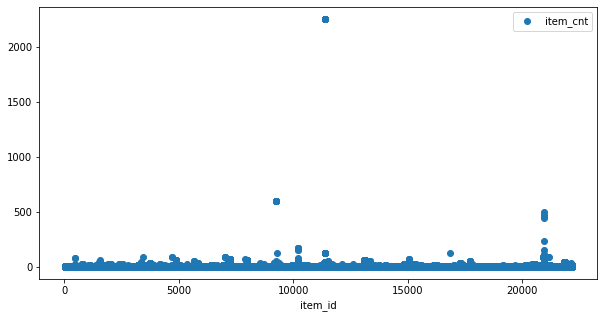

In [21]:
predictedFutureSaleOfItemsDataFrame.plot(x='item_id', y='item_cnt', style='o',figsize=(10, 5))